#Pretrained spliceformer

In [ ]:

!nvidia-smi

!git clone https://github.com/benniatli/Spliceformer.git
%cd Spliceformer

!pip install -r requirements.txt

Tue Nov 25 19:40:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |     372MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import copy
import pyfastx
from src.model import SpliceFormer
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SpliceFormer architecture
model = SpliceFormer(
    CL_max=40000,
    bn_momentum=0.01,
    depth=4,
    heads=4,
    n_transformer_blocks=2,
    determenistic=True,
    crop=False
).to(device)

# Load model
i = 0  # or any number 0–9
ckpt_path = f"/content/Spliceformer/Results/PyTorch_Models/transformer_encoder_45k_finetune_rnasplice-blood_all_050623_{i}"

state = torch.load(ckpt_path, map_location=device)

clean_state = OrderedDict()
for k,v in state.items():
    clean_state[k.replace("module.","")] = v

model.load_state_dict(clean_state)
model.eval()

print("Loaded:", ckpt_path)

ModuleNotFoundError: No module named 'src'

In [ ]:
sequence = "ACGT"

def pad_sequence(sequence, target_length=45000):
    # Calculate the total padding required
    total_padding = target_length - len(sequence)

    # Calculate padding for each side
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding

    # Pad the sequence
    padded_sequence = 'N' * left_padding + sequence + 'N' * right_padding

    return padded_sequence, left_padding, right_padding

def one_hot_encode(sequence):
    # Define the encoding map
    encoding_map = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0]
    }

    # Initialize an array to hold the one-hot encoded sequence
    one_hot_array = np.zeros((len(sequence), 4), dtype=int)

    # Populate the one-hot encoded array
    for i, nucleotide in enumerate(sequence):
        one_hot_array[i] = encoding_map.get(nucleotide, [0, 0, 0, 0])

    return one_hot_array


padded_sequence, left_padding, right_padding = pad_sequence(sequence)
one_hot_array = one_hot_encode(padded_sequence)
one_hot_array = torch.tensor(one_hot_array, dtype=torch.float32).T.unsqueeze(0).to('cuda')

outputs = ([model(one_hot_array)[0].detach() for model in models])
outputs = torch.stack(outputs)
output = torch.mean(outputs,dim=0)
output = output[0,:,left_padding:-right_padding]

print(output)

tensor([[0.0655, 0.0268, 0.0659, 0.1988],
        [0.8518, 0.9705, 0.7773, 0.7975],
        [0.0827, 0.0026, 0.1568, 0.0037]], device='cuda:0')


In [ ]:
data_dir = '../Data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

hg38_fasta_url = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.gz'
hg38_fasta_path = os.path.join(data_dir, 'hg38.fa.gz')

!curl -o {hg38_fasta_path} {hg38_fasta_url}

!gunzip {hg38_fasta_path}





fasta = pyfastx.Fasta('../Data/hg38.fa')



chrom = 'chr5'
pos = 80790685
ref = 'A'
alt = 'G'
strand = '+'



assert ref == fasta[chrom][pos-1:pos-1+len(ref)].seq.upper()



start, end = pos - SL//2 - CL_max//2, pos + SL//2 + CL_max//2
pos_start = pos-start
ref_seq = fasta[chrom][start-1:end-1].seq.upper()
ref_len = len(ref)
alt_len = len(alt)
alt_seq = ref_seq[:pos_start] + alt + ref_seq[(pos_start+ref_len):]

ref_seq_len = len(ref_seq)
alt_seq_len = len(alt_seq)

ref_seq = one_hot_encode(ref_seq)
alt_seq = one_hot_encode(alt_seq)

if strand == '-':
  ref_seq = ref_seq[::-1,::-1].copy()
  alt_seq = alt_seq[::-1,::-1].copy()

ref_seq = torch.tensor(ref_seq, dtype=torch.float32).T.unsqueeze(0).to('cuda')
alt_seq = torch.tensor(alt_seq, dtype=torch.float32).T.unsqueeze(0).to('cuda')

ref_prediction = torch.stack([model(ref_seq)[0].detach() for model in models]).mean(dim=0).cpu().numpy()[0,:,:]
alt_prediction = torch.stack([model(alt_seq)[0].detach() for model in models]).mean(dim=0).cpu().numpy()[0,:,:]




def get_deltas(ref_prediction, alt_prediction, pos_s, crop):
  """

  Args:
    ref_prediction: Splice site scores for all nucleotides in the reference sequence
    alt_prediction: Splice site scores for all nucleotides in the alternative sequence
    pos_s: Variant position minus sequence start position
    crop: Region to crop from both sides of the delta tracks

  Returns: Donor and acceptor delta tracks (difference between alt_prediction and ref_prediction)

  """
  ref_acceptor = ref_prediction[1,:]
  alt_acceptor = alt_prediction[1,:]
  ref_donor = ref_prediction[2,:]
  alt_donor = alt_prediction[2,:]

  delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
  delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
  delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
  delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]
  if ref_seq_len==alt_seq_len:
      delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
      delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
  elif ref_seq_len>alt_seq_len:
      a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
      d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
      delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
      delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

  elif ref_seq_len<alt_seq_len:
      a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
      d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
      delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
      delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

      delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
      delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

  acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
  donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])
  return acceptorDelta[crop:-crop], donorDelta[crop:-crop]

def get_delta_gain_loss(acceptor_delta,donor_delta,chrom,pos):
  acceptor_gain = np.max(acceptor_delta)
  acceptor_gain_pos = f'{chrom}:{np.argmax(acceptor_delta)-5000//2+pos}'
  acceptor_loss = -np.min(acceptor_delta)
  acceptor_loss_pos = f'{chrom}:{np.argmin(acceptor_delta)-5000//2+pos}'
  donor_gain = np.max(donor_delta)
  donor_gain_pos = f'{chrom}:{np.argmax(donor_delta)-5000//2+pos}'
  donor_loss = -np.min(donor_delta)
  donor_loss_pos = f'{chrom}:{np.argmin(donor_delta)-5000//2+pos}'
  df = pd.DataFrame({'Δ type': ['Acceptor Loss', 'Acceptor Gain', 'Donor Loss', 'Donor Gain'], 'Δ': [acceptor_loss,acceptor_gain,donor_loss,donor_gain], 'position':[acceptor_loss_pos,acceptor_gain_pos,donor_loss_pos,donor_gain_pos]})
  return df




acceptor_delta, donor_delta = get_deltas(ref_prediction, alt_prediction, pos_start, CL_max//2)




delta_score = np.max(np.absolute(np.concatenate([acceptor_delta, donor_delta],axis=0)))


print(delta_score)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  965M  100  965M    0     0  56.0M      0  0:00:17  0:00:17 --:--:-- 38.6M
0.07547854


In [ ]:
get_delta_gain_loss(acceptor_delta,donor_delta,chrom,pos)

,Δ type,Δ,position
0,Acceptor Loss,0.042778,chr5:80790975
1,Acceptor Gain,0.009104,chr5:80789462
2,Donor Loss,0.029338,chr5:80790170
3,Donor Gain,0.075479,chr5:80790975


##Dataset hg38

In [ ]:
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.annotation.gtf.gz

--2025-11-24 18:32:23--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49721965 (47M) [application/x-gzip]
Saving to: ‘gencode.v44.annotation.gtf.gz’

gencode.v44.annotat 100%[===================>]  47.42M  19.3MB/s    in 2.5s    

2025-11-24 18:32:26 (19.3 MB/s) - ‘gencode.v44.annotation.gtf.gz’ saved [49721965/49721965]



In [ ]:
!gunzip gencode.v44.annotation.gtf.gz

In [ ]:
import pyfastx
from tqdm import tqdm

GENOME = "../Data/hg38.fa"
GTF = "gencode.v44.annotation.gtf"

fasta = pyfastx.Fasta(GENOME)

donor_sites = []
acceptor_sites = []

with open(GTF, "r") as fh:
    for line in fh:
        if line.startswith("#"):
            continue

        fields = line.strip().split("\t")
        if fields[2] != "exon":
            continue

        chrom = fields[0]
        start = int(fields[3])
        end = int(fields[4])
        strand = fields[6]

        if strand == "+":
            acceptor_sites.append((chrom, start, strand))
            donor_sites.append((chrom, end, strand))
        else:
            acceptor_sites.append((chrom, end, strand))
            donor_sites.append((chrom, start, strand))

print("Total acceptor sites:", len(acceptor_sites))
print("Total donor sites:", len(donor_sites))


Total acceptor sites: 1649476
Total donor sites: 1649476


##spliceformer test with hg38 dataset

In [ ]:
WINDOW = 4000          # total window size
HALF = WINDOW // 2     # 2000


def extract_window(chrom, pos, strand):
    start = pos - HALF
    end   = pos + HALF

    # Extract sequence (inclusive start, exclusive end)
    seq = fasta[chrom][start-1:end-1].seq.upper()

    if len(seq) != WINDOW:
        return None

    # Reverse complement for negative strand
    if strand == "-":
        rc = str.maketrans("ACGT", "TGCA")
        seq = seq.translate(rc)[::-1]

    return seq



In [ ]:
def one_hot_encode(seq):
    mapping = {'A':0,'C':1,'G':2,'T':3}
    arr = np.zeros((4, len(seq)), dtype=np.float32)
    for i, nt in enumerate(seq):
        if nt in mapping:
            arr[mapping[nt], i] = 1.0
    return arr



def predict_spliceformer(seq):
    x = one_hot_encode(seq)               # (4, L)
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # (1,4,L)

    with torch.no_grad():
        preds = [model(x)[0].detach().cpu().numpy() for model in models]

    return np.mean(preds, axis=0)[0]      # (3, L)


In [ ]:
from tqdm import tqdm
import numpy as np

N = 200

donor_scores = []
acceptor_scores = []

print("Processing donor sites (4000 bp windows)...")
for chrom, pos, strand in tqdm(donor_sites[:N]):
    seq = extract_window(chrom, pos, strand)
    if seq is None:
        continue
    pred = predict_spliceformer(seq)
    donor_scores.append(pred[2])  # donor channel

print("Processing acceptor sites (4000 bp windows)...")
for chrom, pos, strand in tqdm(acceptor_sites[:N]):
    seq = extract_window(chrom, pos, strand)
    if seq is None:
        continue
    pred = predict_spliceformer(seq)
    acceptor_scores.append(pred[1])  # acceptor channel

donor_scores = np.array(donor_scores)
acceptor_scores = np.array(acceptor_scores)

print("Done.")

Processing donor sites (4000 bp windows)...


100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Processing acceptor sites (4000 bp windows)...


100%|██████████| 200/200 [00:27<00:00,  7.38it/s]

Done.


In [ ]:
donor_mean = donor_scores.mean(axis=0)
acceptor_mean = acceptor_scores.mean(axis=0)

In [ ]:
print(donor_mean)
print(acceptor_mean)

[0.25748345 0.25872478 0.25641564 ... 0.27637333 0.277761   0.2777286 ]
[0.34366632 0.34576318 0.34908918 ... 0.33768556 0.33861473 0.3386143 ]


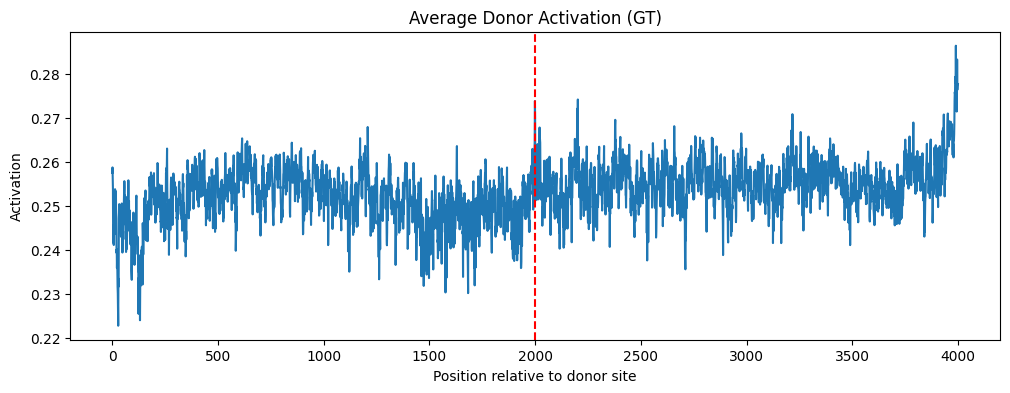

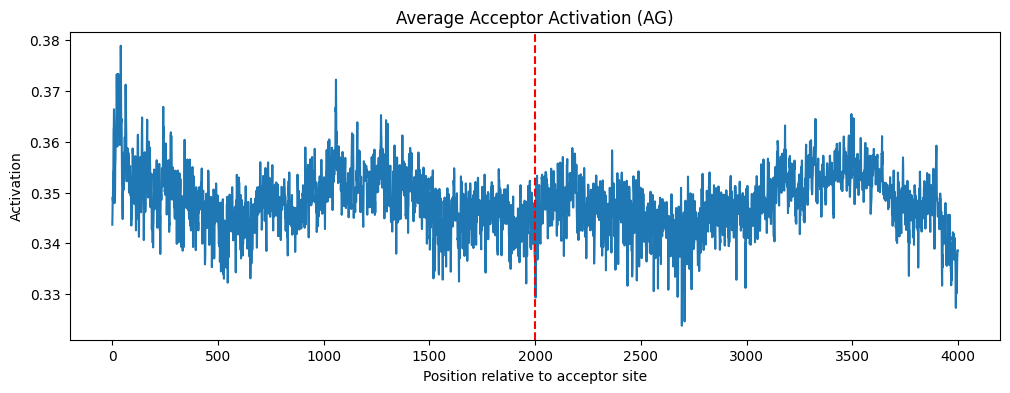

In [ ]:
import matplotlib.pyplot as plt

center = HALF

plt.figure(figsize=(12,4))
plt.plot(donor_mean)
plt.axvline(center, color='red', linestyle='--')
plt.title("Average Donor Activation (GT)")
plt.xlabel("Position relative to donor site")
plt.ylabel("Activation")
plt.show()


plt.figure(figsize=(12,4))
plt.plot(acceptor_mean)
plt.axvline(center, color='red', linestyle='--')
plt.title("Average Acceptor Activation (AG)")
plt.xlabel("Position relative to acceptor site")
plt.ylabel("Activation")
plt.show()

In [ ]:

def one_hot_encode(seq):
    mapping = {'A':0,'C':1,'G':2,'T':3,'N':-1}
    arr = np.zeros((len(seq), 4), dtype=np.float32)
    for i, ch in enumerate(seq):
        idx = mapping.get(ch.upper(), -1)
        if idx >= 0:
            arr[i, idx] = 1.
    return arr



def spliceformer_score(short_seq, model, window=45000):
    short_seq = short_seq.upper()

    # Pad short sequence into a 45k window
    left = (window - len(short_seq)) // 2
    right = window - len(short_seq) - left
    full_seq = "N"*left + short_seq + "N"*right

    x = one_hot_encode(full_seq)
    x = torch.tensor(x).float().transpose(0,1).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)[0].squeeze(0).cpu().numpy()

    center = window // 2
    donor = out[2, center]
    acceptor = out[1, center]
    return donor, acceptor


def interpret(donor, acceptor):
    if donor > 0.80 or acceptor > 0.80:
        return "STRONG splice site!"
    elif donor > 0.50 or acceptor > 0.50:
        return "Weak splice site"
    else:
        return "Not a splice site"


def extract_real_sequence(chrom, pos, strand, window=200):
    start = pos - window//2
    end   = pos + window//2

    seq = fasta[chrom][start-1:end-1].seq.upper()

    # reverse complement for negative strand
    if strand == "-":
        comp = {'A':'T','T':'A','C':'G','G':'C','N':'N'}
        seq = "".join(comp.get(b, "N") for b in seq[::-1])

    return seq


def test_real_splice_site(site):
    chrom, pos, strand = site
    seq = extract_real_sequence(chrom, pos, strand)

    donor, acceptor = spliceformer_score(seq, model)

    print("Chrom:", chrom, "Pos:", pos, "Strand:", strand)
    print("Sequence (200 bp around site):")
    print(seq)
    print(f"Donor score:    {donor:.3f}")
    print(f"Acceptor score: {acceptor:.3f}")
    print("Verdict:", interpret(donor, acceptor))


In [ ]:
example_donor = donor_sites[0]
example_acceptor = acceptor_sites[0]

print("real donor")
test_real_splice_site(example_donor)

print("\nreal acceptor")
test_real_splice_site(example_acceptor)

real donor
Chrom: chr1 Pos: 12227 Strand: +
Sequence (200 bp around site):
GCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGATTGGAGGAAAGATGAGTGAGAGCATCAACTTCTCTCACAACCTAGGCCAGTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGCCGGCCCTCGCTCCAGCAGCTGGACCCCTACCTGCCGTCTGCTGCCATCGGAGCCCA
Donor score:    0.880
Acceptor score: 0.000
Verdict: STRONG splice site!

real acceptor
Chrom: chr1 Pos: 11869 Strand: +
Sequence (200 bp around site):
TGAGAATGACTGCGCAAATTTGCCGGATTTCCTTTGCTGTTCCTGCATGTAGTTTAAACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTATTTGCTGTCTCTTAGCCCAGACTTCCCGTGTCCTTTCCACCGGGCCTTT
Donor score:    0.001
Acceptor score: 0.000
Verdict: Not a splice site


#Saliency

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Saliency: gradient of prediction wrt input sequence
def compute_saliency(short_seq, model, target="donor", window=45000):
    short_seq = short_seq.upper()

    # pad into 45k window
    left_pad = (window - len(short_seq)) // 2
    right_pad = window - len(short_seq) - left_pad
    full_seq = "N"*left_pad + short_seq + "N"*right_pad

    # one-hot encode with gradient
    mapping = {'A':0,'C':1,'G':2,'T':3,'N':-1}
    x = np.zeros((window, 4), dtype=np.float32)
    for i, ch in enumerate(full_seq):
        idx = mapping.get(ch, -1)
        if idx >= 0:
            x[i, idx] = 1.

    x = torch.tensor(x).float().transpose(0,1).unsqueeze(0).to(device)
    x.requires_grad = True

    # forward pass
    out = model(x)[0].squeeze(0)

    center = window // 2
    donor_score = out[2, center]
    acceptor_score = out[1, center]

    if target == "donor":
        target_score = donor_score
    else:
        target_score = acceptor_score

    # compute gradient
    model.zero_grad()
    target_score.backward()

    # saliency = |gradient * input|
    saliency = x.grad.detach().cpu().numpy()
    saliency = np.abs(saliency) * x.detach().cpu().numpy()

    # reduce 4 channels → single score
    saliency = saliency.sum(axis=1).flatten()

    # extract only the short sequence part
    saliency_short = saliency[left_pad: left_pad + len(short_seq)]

    return saliency_short

In [ ]:
def plot_saliency(seq, saliency, title):
    plt.figure(figsize=(16,4))
    plt.plot(saliency, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel("Position in 200 bp window")
    plt.ylabel("Saliency (importance)")
    plt.grid(alpha=0.3)
    plt.show()


    max_pos = np.argmax(saliency)
    print(f"Most important base: {seq[max_pos]} at position {max_pos}")

In [ ]:
def extract_real_seq(chrom, pos, strand, window=200):
    start = pos - window//2
    end   = pos + window//2
    seq = fasta[chrom][start-1:end-1].seq.upper()

    if strand == '-':
        comp = {'A':'T','T':'A','C':'G','G':'C','N':'N'}
        seq = "".join(comp.get(b,'N') for b in seq[::-1])
    return seq

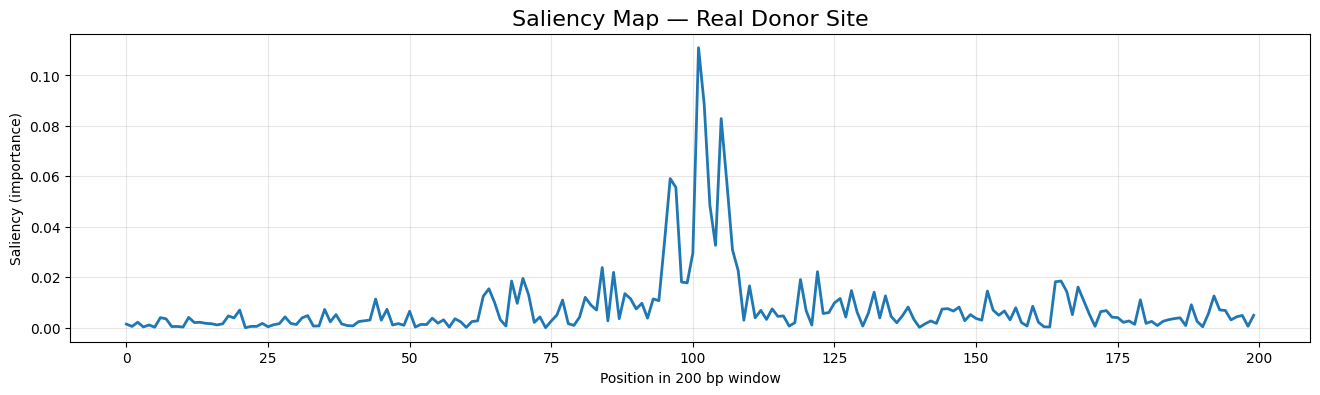

Most important base: G at position 101


In [ ]:
chrom, pos, strand = donor_sites[0]
seq = extract_real_seq(chrom, pos, strand, window=200)

sal = compute_saliency(seq, model, target="donor")
plot_saliency(seq, sal, "Saliency Map — Real Donor Site")

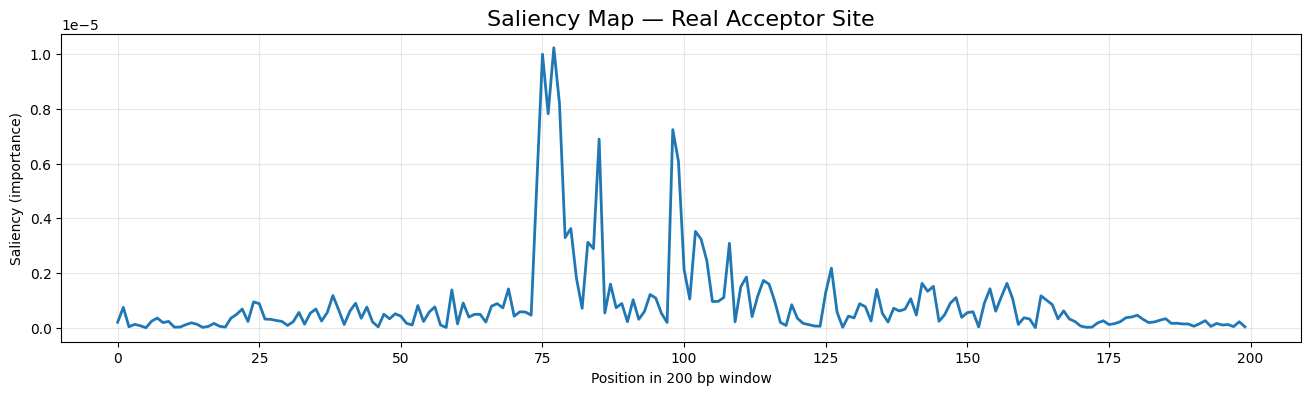

Most important base: T at position 77


In [ ]:
chrom, pos, strand = acceptor_sites[0]
seq = extract_real_seq(chrom, pos, strand, window=200)

sal = compute_saliency(seq, model, target="acceptor")
plot_saliency(seq, sal, "Saliency Map — Real Acceptor Site")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 200          # number of splice sites to sample
WINDOW = 200     # 200 bp window (same as before)

# Matrices: N × WINDOW
acceptor_matrix = []
donor_matrix = []

print("Processing acceptor sites...")
for chrom, pos, strand in tqdm(acceptor_sites[:N]):
    seq = extract_real_seq(chrom, pos, strand, window=WINDOW)
    sal = compute_saliency(seq, model, target="acceptor")
    acceptor_matrix.append(sal)

print("Processing donor sites...")
for chrom, pos, strand in tqdm(donor_sites[:N]):
    seq = extract_real_seq(chrom, pos, strand, window=WINDOW)
    sal = compute_saliency(seq, model, target="donor")
    donor_matrix.append(sal)

acceptor_matrix = np.array(acceptor_matrix)
donor_matrix = np.array(donor_matrix)

print("Done.")


Processing acceptor sites...


100%|██████████| 200/200 [00:27<00:00,  7.40it/s]


Processing donor sites...


100%|██████████| 200/200 [00:25<00:00,  7.73it/s]

Done.


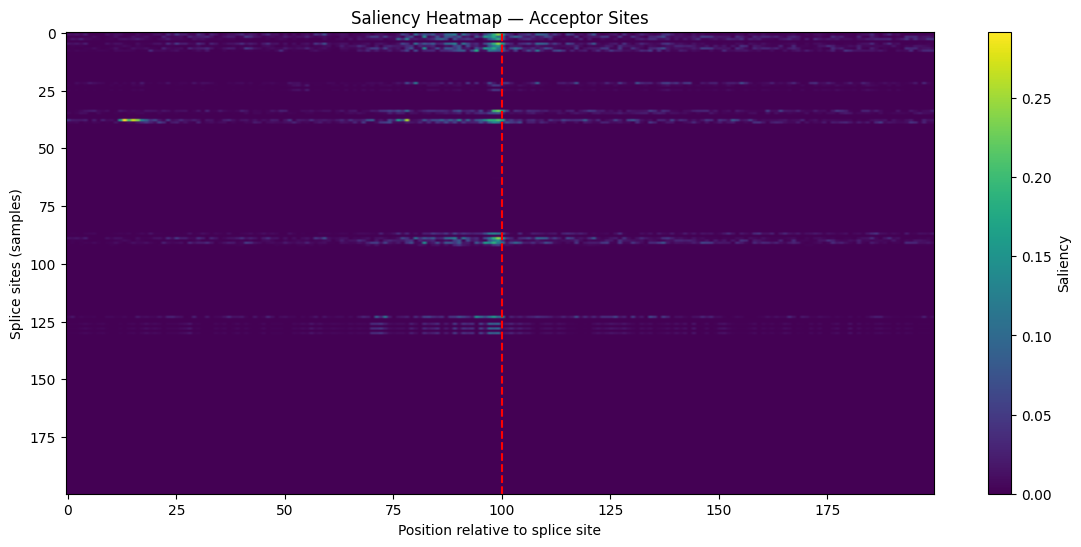

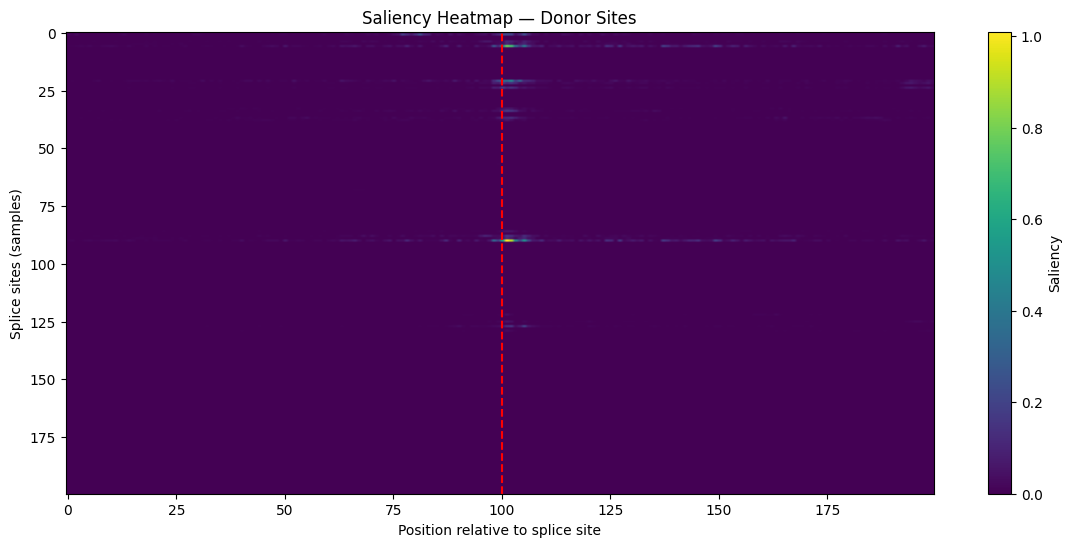

In [ ]:
def plot_heatmap(mat, title):
    plt.figure(figsize=(14,6))
    plt.imshow(mat, aspect='auto', cmap='viridis')
    plt.colorbar(label="Saliency")
    plt.title(title)
    plt.xlabel("Position relative to splice site")
    plt.ylabel("Splice sites (samples)")
    plt.axvline(WINDOW//2, color='red', linestyle='--')
    plt.show()


plot_heatmap(acceptor_matrix, "Saliency Heatmap — Acceptor Sites")
plot_heatmap(donor_matrix, "Saliency Heatmap — Donor Sites")


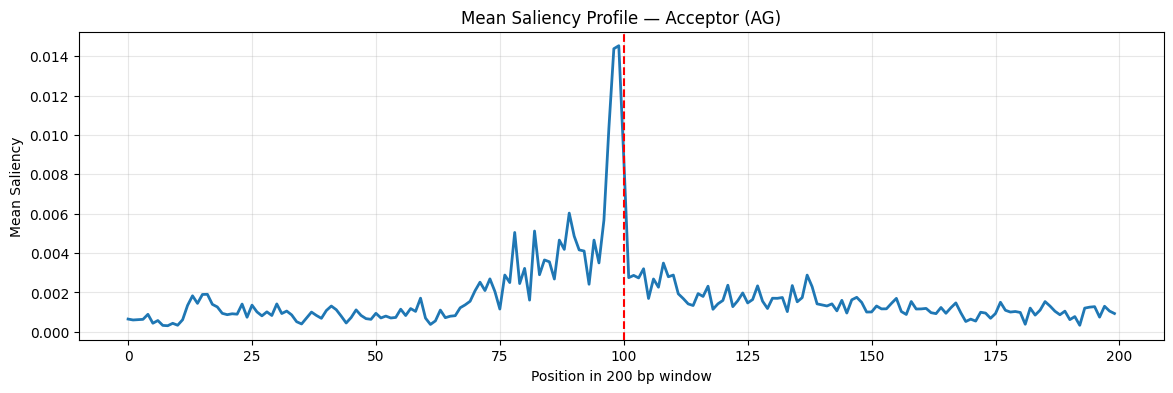

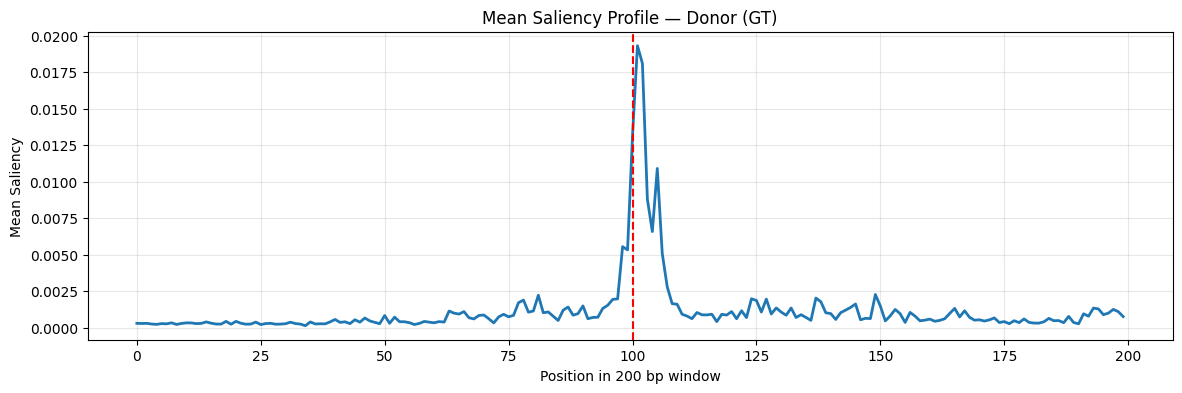

In [ ]:
def plot_mean_profile(mat, title):
    mean_sal = mat.mean(axis=0)
    plt.figure(figsize=(14,4))
    plt.plot(mean_sal, linewidth=2)
    plt.axvline(WINDOW//2, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Position in 200 bp window")
    plt.ylabel("Mean Saliency")
    plt.grid(alpha=0.3)
    plt.show()

plot_mean_profile(acceptor_matrix, "Mean Saliency Profile (Acceptor)")
plot_mean_profile(donor_matrix, "Mean Saliency Profile (Donor)")

In [ ]:
def spliceformer_score(short_seq, model, window=45000):
    short_seq = short_seq.upper()

    # Pad short sequence into a 45k window
    left = (window - len(short_seq)) // 2
    right = window - len(short_seq) - left
    full_seq = "N"*left + short_seq + "N"*right

    # one-hot encode WITH gradient
    mapping = {'A':0,'C':1,'G':2,'T':3,'N':-1}
    x = np.zeros((window, 4), dtype=np.float32)
    for i, ch in enumerate(full_seq):
        idx = mapping.get(ch, -1)
        if idx >= 0:
            x[i, idx] = 1.

    x = torch.tensor(x).float().transpose(0,1).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)[0].squeeze(0).cpu().numpy()

    center = window // 2
    donor = out[2, center]
    acceptor = out[1, center]
    return donor, acceptor


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

BASES = ["A", "C", "G", "T"]

def mutagenesis_profile(seq, model, target="donor", window=45000):

    seq = seq.upper()
    L = len(seq)

    # original score
    orig_donor, orig_acceptor = spliceformer_score(seq, model, window=window)
    orig_score = orig_donor if target == "donor" else orig_acceptor

    effect_matrix = np.zeros((L, 4), dtype=np.float32)

    for i in range(L):
        for b_idx, b in enumerate(BASES):
            if seq[i] == b:

                effect_matrix[i, b_idx] = 0.0
                continue

            mutated = list(seq)
            mutated[i] = b
            mutated = "".join(mutated)

            d_score, a_score = spliceformer_score(mutated, model, window=window)
            new_score = d_score if target == "donor" else a_score

            # positive value = mutation lowers the score
            effect_matrix[i, b_idx] = orig_score - new_score

    return effect_matrix, orig_score


In [ ]:
def plot_mutagenesis_profile(seq, effect_matrix, target_label):

    L = effect_matrix.shape[0]
    max_drop = effect_matrix.max(axis=1)  # (L,)

    plt.figure(figsize=(14,4))
    plt.plot(max_drop, linewidth=2)
    plt.axvline(L//2, color='red', linestyle='--')
    plt.title(f"In-silico mutagenesis {target_label}")
    plt.xlabel("Position in 200 bp window")
    plt.ylabel("Max score drop (orig - mutated)")
    plt.grid(alpha=0.3)
    plt.show()


    max_pos = np.argmax(max_drop)
    print(f"Most sensitive position: {max_pos}, base = {seq[max_pos]}")


Original donor score: 0.880


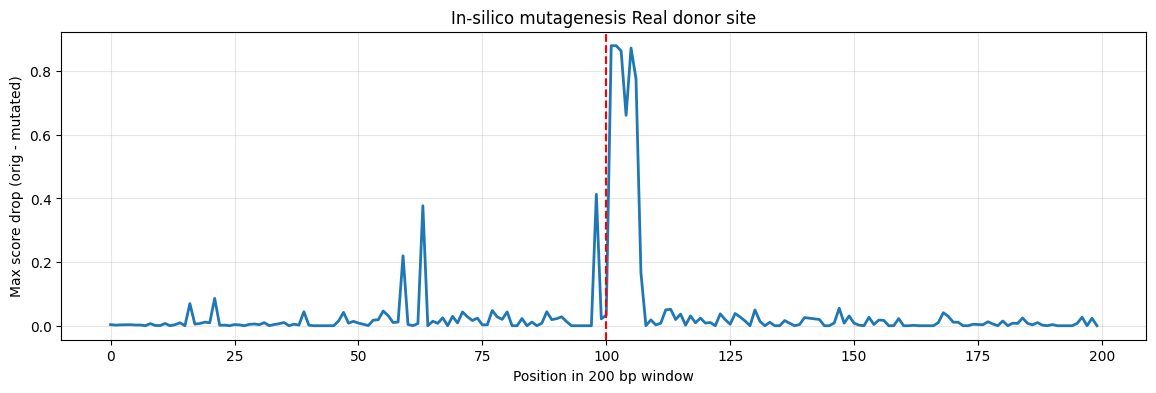

Most sensitive position: 102, base = T
Original acceptor score: 0.000


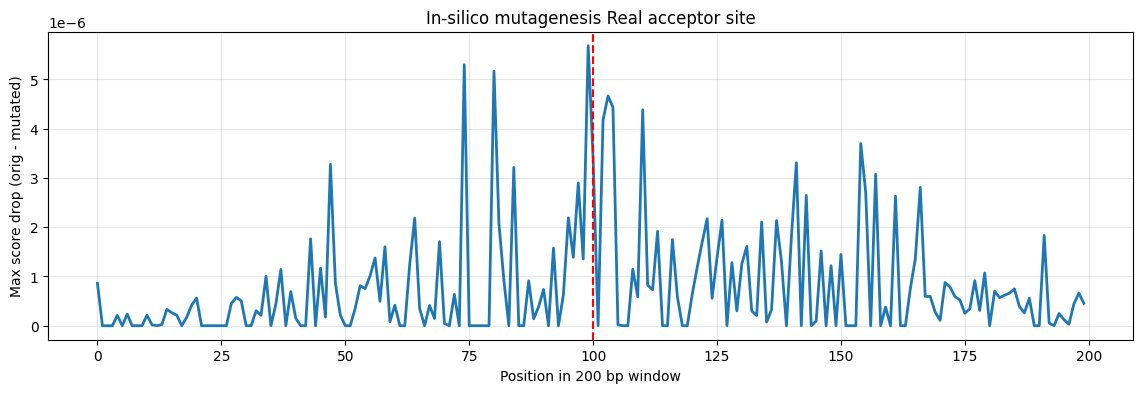

Most sensitive position: 99, base = C


In [ ]:
# Real donor
chrom, pos, strand = donor_sites[0]
seq_donor = extract_real_seq(chrom, pos, strand, window=200)
eff_donor, orig_donor = mutagenesis_profile(seq_donor, model, target="donor")
print(f"Original donor score: {orig_donor:.3f}")
plot_mutagenesis_profile(seq_donor, eff_donor, target_label="Real donor site")

# Real acceptor
chrom, pos, strand = acceptor_sites[0]
seq_acc = extract_real_seq(chrom, pos, strand, window=200)
eff_acc, orig_acc = mutagenesis_profile(seq_acc, model, target="acceptor")
print(f"Original acceptor score: {orig_acc:.3f}")
plot_mutagenesis_profile(seq_acc, eff_acc, target_label="Real acceptor site")


In [ ]:
import random

def shuffle_sequence(seq):
    seq_list = list(seq)
    random.shuffle(seq_list)
    return "".join(seq_list)


In [ ]:
def test_real_vs_random(site, target="donor", n_random=20):
    chrom, pos, strand = site

    # extract real 200bp window
    real_seq = extract_real_seq(chrom, pos, strand, window=200)
    real_d, real_a = spliceformer_score(real_seq, model)
    real_score = real_d if target=="donor" else real_a

    random_scores = []

    for i in range(n_random):
        rand_seq = shuffle_sequence(real_seq)
        d, a = spliceformer_score(rand_seq, model)
        score = d if target=="donor" else a
        random_scores.append(score)

    return real_score, random_scores


In [ ]:
def plot_real_vs_random(real_score, random_scores, title):
    plt.figure(figsize=(7,4))
    plt.boxplot([random_scores, [real_score]], labels=['Random', 'Real'])
    plt.title(title)
    plt.ylabel("Model Score")
    plt.grid(alpha=0.3)
    plt.show()

    print("Real score:", real_score)
    print("Random mean:", sum(random_scores)/len(random_scores))


/tmp/ipython-input-1352508463.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([random_scores, [real_score]], labels=['Random', 'Real'])


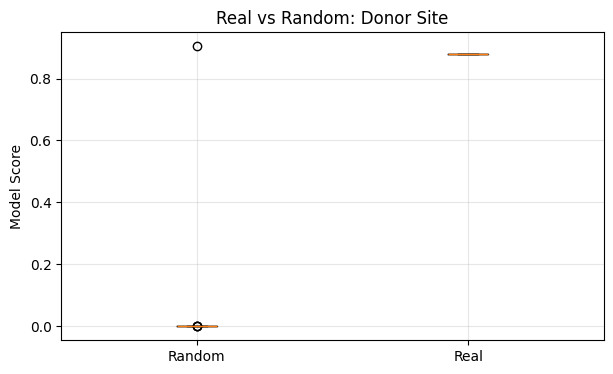

Real score: 0.8800723
Random mean: 0.04521931


/tmp/ipython-input-1352508463.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([random_scores, [real_score]], labels=['Random', 'Real'])


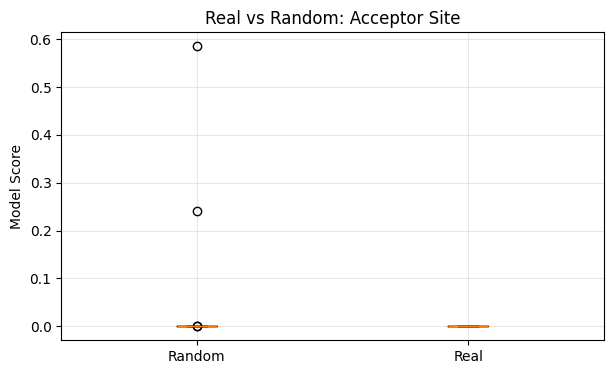

Real score: 7.186393e-06
Random mean: 0.041293852


In [ ]:
# donor
real_donor_score, rand_donor_scores = test_real_vs_random(donor_sites[0], target="donor")
plot_real_vs_random(real_donor_score, rand_donor_scores,
                    "Real vs Random: Donor Site")

# acceptor
real_acc_score, rand_acc_scores = test_real_vs_random(acceptor_sites[0], target="acceptor")
plot_real_vs_random(real_acc_score, rand_acc_scores,
                    "Real vs Random: Acceptor Site")



 TESTING REAL VS RANDOM SEQUENCES

 Real donor site
Sequence (first 40bp): GCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGC...
Donor score:    0.880
Acceptor score: 0.000

 Real acceptor site
Sequence (first 40bp): TGAGAATGACTGCGCAAATTTGCCGGATTTCCTTTGCTGT...
Donor score:    0.001
Acceptor score: 0.000

 Shuffled donor (control)
Sequence (first 40bp): ACTTGGGACGGAAGTCCTCGCTCGGATGGGCGGCATCCTA...
Donor score:    0.000
Acceptor score: 0.000

 Random DNA
Sequence (first 40bp): TAATCTTTCTAGTCTGTACGCCTAATCTAGGACTGAAAAC...
Donor score:    0.000
Acceptor score: 0.000

 WHAT 2-LETTER PATTERNS DOES THE MODEL LIKE?

Top patterns by DONOR score:
  CC: donor score = 0.000
  CG: donor score = 0.000
  GG: donor score = 0.000
  TC: donor score = 0.000
  TG: donor score = 0.000

Top patterns by ACCEPTOR score:
  CA: acceptor score = 0.000083
  CT: acceptor score = 0.000072
  CC: acceptor score = 0.000068
  CG: acceptor score = 0.000066
  AC: acceptor score = 0.000061


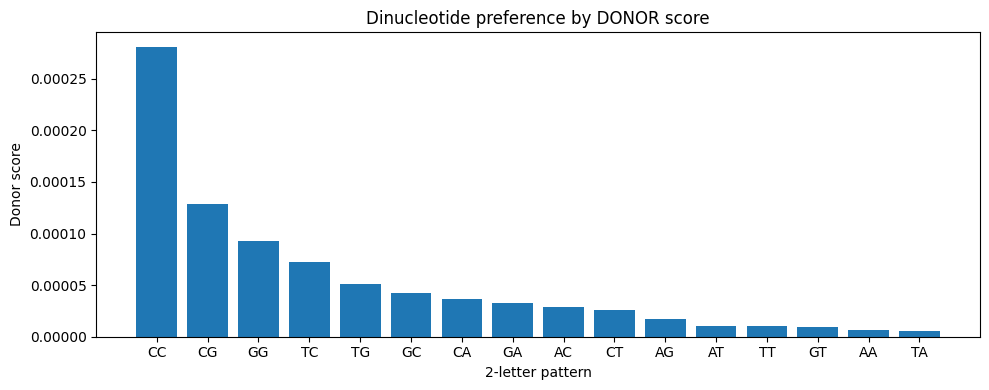

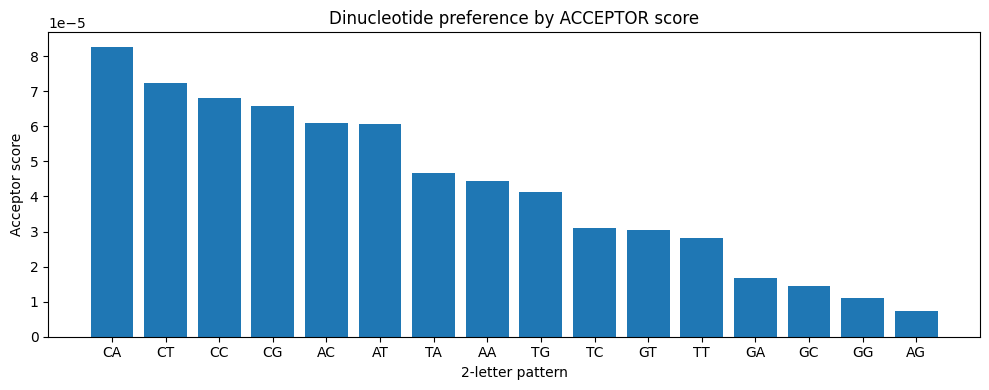

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random



def real_test_what_model_learned():


    print("\n TESTING REAL VS RANDOM SEQUENCES")


    # real donor and acceptor from your dataset
    real_donor_site = donor_sites[0]
    real_acceptor_site = acceptor_sites[0]

    # 200 bp windows
    donor_seq   = extract_real_seq(*real_donor_site, window=200)
    acceptor_seq = extract_real_seq(*real_acceptor_site, window=200)

    # random genomic window: just shuffle donor sequence as a control
    shuffled_seq = list(donor_seq)
    random.shuffle(shuffled_seq)
    shuffled_seq = "".join(shuffled_seq)

    # another totally random sequence (same length, random A/C/G/T)
    rand_seq = "".join(random.choice("ACGT") for _ in range(len(donor_seq)))

    test_seqs = {
        "Real donor site": donor_seq,
        "Real acceptor site": acceptor_seq,
        "Shuffled donor (control)": shuffled_seq,
        "Random DNA": rand_seq,
    }

    for desc, seq in test_seqs.items():
        d_score, a_score = spliceformer_score(seq, model)
        print(f"\n {desc}")
        print(f"Sequence (first 40bp): {seq[:40]}...")
        print(f"Donor score:    {d_score:.3f}")
        print(f"Acceptor score: {a_score:.3f}")



def real_discover_patterns():

    print("\n WHAT 2-LETTER PATTERNS DOES THE MODEL LIKE?")


    letters = ["A", "C", "G", "T"]
    patterns = {}


    L = 200
    center = L // 2

    for a in letters:
        for b in letters:
            pat = a + b
            bg = ["A"] * L
            bg[center] = a
            bg[center+1] = b
            seq = "".join(bg)

            d_score, a_score = spliceformer_score(seq, model)
            patterns[pat] = (d_score, a_score)

    # sort by donor score and acceptor score
    sorted_by_donor = sorted(patterns.items(), key=lambda x: x[1][0], reverse=True)
    sorted_by_acceptor = sorted(patterns.items(), key=lambda x: x[1][1], reverse=True)

    print("\nTop patterns by DONOR score:")
    for pat, (ds, _) in sorted_by_donor[:5]:
        print(f"  {pat}: donor score = {ds:.3f}")

    print("\nTop patterns by ACCEPTOR score:")
    for pat, (_, ac) in sorted_by_acceptor[:5]:
        print(f"  {pat}: acceptor score = {ac:.6f}")

    # visualize donor patterns
    names = [p for p,_ in sorted_by_donor]
    donor_scores = [s[0] for _,s in sorted_by_donor]

    plt.figure(figsize=(10,4))
    plt.bar(names, donor_scores)
    plt.title("Dinucleotide preference by DONOR score")
    plt.xlabel("2-letter pattern")
    plt.ylabel("Donor score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # visualize acceptor patterns
    names_a = [p for p,_ in sorted_by_acceptor]
    acc_scores = [s[1] for _,s in sorted_by_acceptor]

    plt.figure(figsize=(10,4))
    plt.bar(names_a, acc_scores)
    plt.title("Dinucleotide preference by ACCEPTOR score")
    plt.xlabel("2-letter pattern")
    plt.ylabel("Acceptor score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


real_test_what_model_learned()
real_discover_patterns()



#SplieAI
I started but could not complete due to time constraints

In [ ]:
!git clone https://github.com/Illumina/SpliceAI
%cd SpliceAI

Cloning into 'SpliceAI'...
remote: Enumerating objects: 663, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 663 (delta 131), reused 121 (delta 121), pack-reused 521 (from 3)
Receiving objects: 100% (663/663), 18.33 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (402/402), done.
/content/SpliceAI/SpliceAI


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf

# Load each of the 5 SpliceAI models
model_paths = [
    "/content/SpliceAI/spliceai/models/spliceai1.h5",
    "/content/SpliceAI/spliceai/models/spliceai2.h5",
    "/content/SpliceAI/spliceai/models/spliceai3.h5",
    "/content/SpliceAI/spliceai/models/spliceai4.h5",
    "/content/SpliceAI/spliceai/models/spliceai5.h5"
]

models = [tf.keras.models.load_model(model_path) for model_path in model_paths]

In [ ]:
import tensorflow as tf

model_path = "/content/SpliceAI/spliceai/models/spliceai1.h5"
model = tf.keras.models.load_model(model_path)

print("Model loaded!")

Model loaded!


In [ ]:
import os

data_dir = '../Data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

hg38_fasta_url = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.gz'
hg38_fasta_path = os.path.join(data_dir, 'hg38.fa.gz')

!curl -o {hg38_fasta_path} {hg38_fasta_url}

!gunzip {hg38_fasta_path}





hg38 = pyfastx.Fasta('../Data/hg38.fa')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  965M  100  965M    0     0  16.7M      0  0:00:57  0:00:57 --:--:-- 19.3M
gzip: ../Data/hg38.fa already exists; do you wish to overwrite (y or n)? n
	not overwritten


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Donor Scores: [6.366676e-08 6.366676e-08 6.366676e-08 6.366676e-08 6.366664e-08
 6.366676e-08 6.366664e-08 6.366676e-08 6.366652e-08 6.366664e-08]
Acceptor Scores: [1.6045834e-07 1.6045834e-07 1.6045804e-07 1.6045834e-07 1.6045819e-07
 1.6045834e-07 1.6045819e-07 1.6045834e-07 1.6045819e-07 1.6045804e-07]


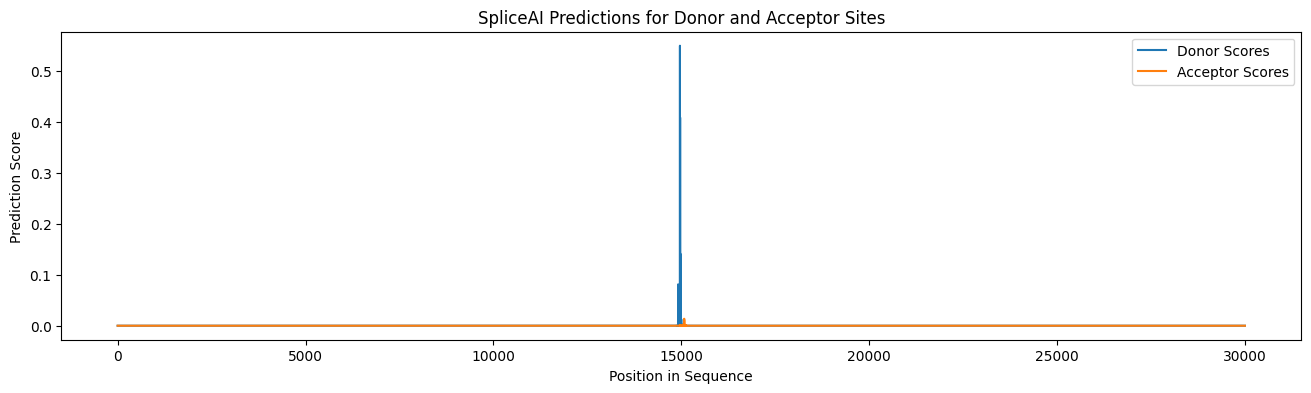

In [ ]:
import pyfastx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



# Function to extract 200-bp sequence around splice site
def extract_sequence(chrom, pos, window=200):
    start = pos - window // 2
    end = pos + window // 2
    seq = hg38[chrom][start-1:end-1].seq.upper()  # Extract sequence from hg38
    return seq

# Function to pad the sequence to the required length (40,000 bp for SpliceAI)
def pad_sequence_to_size(seq, target_size=40000):
    seq_len = len(seq)
    left_padding = (target_size - seq_len) // 2
    right_padding = target_size - seq_len - left_padding
    padded_seq = 'N' * left_padding + seq + 'N' * right_padding
    return padded_seq

# One-hot encoding function
def one_hot_encode(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    arr = np.zeros((len(seq), 4), dtype=np.float32)
    for i, nt in enumerate(seq):
        if nt in mapping:
            arr[i, mapping[nt]] = 1.0
    return arr



# Example donor sites (chromosome, position, strand)
donor_sites = [("chr19", 46022633, "+"), ("chr1", 23456789, "-")]

# Extract, pad, one-hot encode, and get predictions for donor sequences
donor_sequences = [extract_sequence(chrom, pos, window=200) for chrom, pos, strand in donor_sites]

# Pad sequences to 40,000 bp
donor_sequences_padded = [pad_sequence_to_size(seq, target_size=40000) for seq in donor_sequences]

# One-hot encode the padded sequences
donor_encoded = [one_hot_encode(seq) for seq in donor_sequences_padded]

# Get predictions for the first donor sequence
x = donor_encoded[0]  # One-hot encoded donor sequence (shape: (40000, 4))
x = np.expand_dims(x, axis=0)  # Add batch dimension: (1, 40000, 4)

# Get predictions (shape: (40000, 3))
preds = model.predict(x)[0]

# Donor and Acceptor Scores (model output)
donor_scores = preds[:, 2]  # Donor channel
acceptor_scores = preds[:, 1]  # Acceptor channel

print("Donor Scores:", donor_scores[:10])  # Print first 10 donor scores
print("Acceptor Scores:", acceptor_scores[:10])  # Print first 10 acceptor scores

# Plot the results for the first donor sequence
plt.figure(figsize=(16, 4))
plt.plot(donor_scores, label="Donor Scores")
plt.plot(acceptor_scores, label="Acceptor Scores")
plt.legend()
plt.title("SpliceAI Predictions for Donor and Acceptor Sites")
plt.xlabel("Position in Sequence")
plt.ylabel("Prediction Score")
plt.show()
